In [1282]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


# **Loading The Data**

In [1283]:
df = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 0)

In [1284]:
df.head()

,Date,Open,Close,Volume,Strategy
id,,,,,
0,2015-06-01,66.208486,75.609978,298506300,Hold
1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2015-06-15,47.701942,71.140831,250670900,Buy
3,2015-06-22,54.754816,72.881344,223614300,Hold
4,2015-06-29,48.031899,66.284718,406814900,Buy


In [1285]:
# Defining the mapping dictionary to make it like one hot encoded
strategy_mapping = {'Hold': 0, 'Buy': 1, 'Sell': 2}

# Applying the mapping to the 'Strategy' column
df['Strategy'] = df['Strategy'].map(strategy_mapping)
df.head()

,Date,Open,Close,Volume,Strategy
id,,,,,
0,2015-06-01,66.208486,75.609978,298506300,0
1,2015-06-08,64.116235,74.443331,227974800,0
2,2015-06-15,47.701942,71.140831,250670900,1
3,2015-06-22,54.754816,72.881344,223614300,0
4,2015-06-29,48.031899,66.284718,406814900,1


# **Statistics Of Dataset And Inspection Of NULL Values**

In [1286]:
#Summary statistics of the dataset
df.describe()

,Open,Close,Volume,Strategy
count,300.000000,300.000000,3.000000e+02,300.000000
mean,75.977813,79.430489,1.866300e+08,0.786667
std,16.158343,13.878395,7.952792e+07,0.834752
min,40.269435,47.979353,5.991330e+07,0.000000
25%,64.872395,69.689227,1.324862e+08,0.000000
50%,79.805683,82.991900,1.715536e+08,1.000000
75%,88.342927,89.719145,2.201842e+08,2.000000
max,102.558322,103.119373,6.935702e+08,2.000000


In [1287]:
print(df.isna().sum(),"\n")
print(df.info())
#No NULL Values

Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      300 non-null    object 
 1   Open      300 non-null    float64
 2   Close     300 non-null    float64
 3   Volume    300 non-null    int64  
 4   Strategy  300 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 14.1+ KB
None


In [1288]:
#Setting Date attribute as datetime type to make our work comfortable
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
#Setting date as index 
df.set_index('Date',inplace=True)

/tmp/ipykernel_32/3283811556.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


# **Making Some Sense Of Data Through The Data Visualisations**

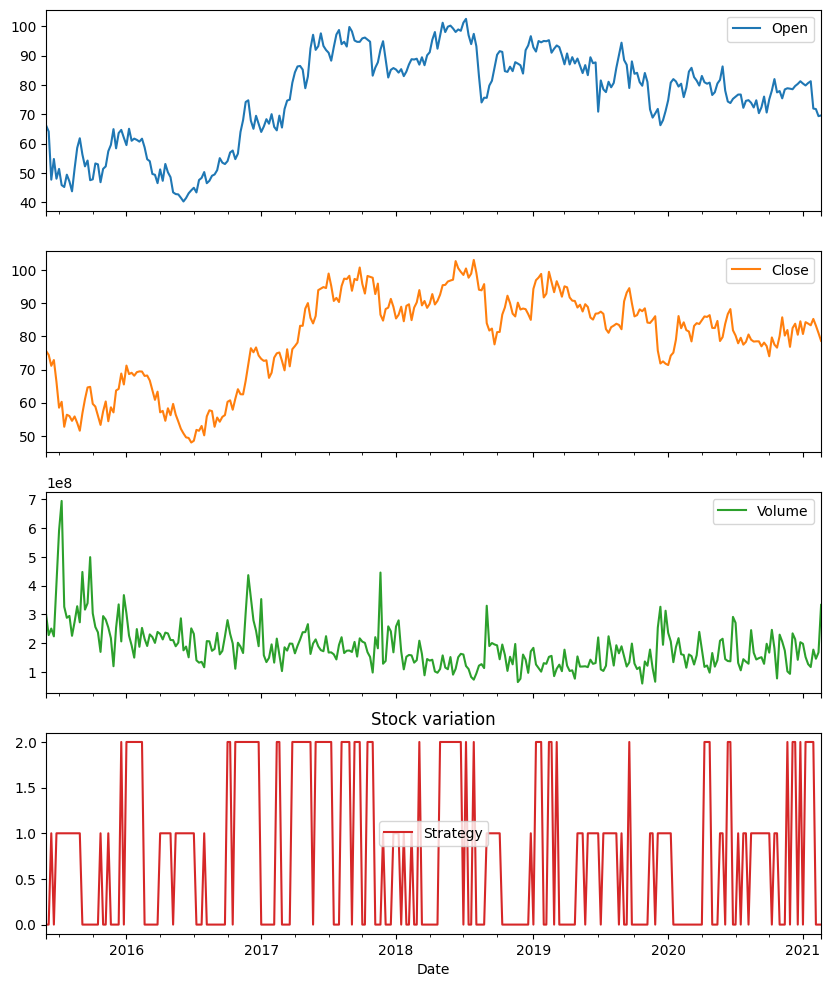

In [1289]:
import matplotlib.pyplot as plt
#Looking at variation of the stock trends
df.plot(subplots=True, figsize=(10,12))
plt.title('Stock variation')
plt.show()

# **Inference Drawn**
**Open And Close Shows Some Upward Trend,But Volume Seems To Have Irregularity**

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_32/747589482.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


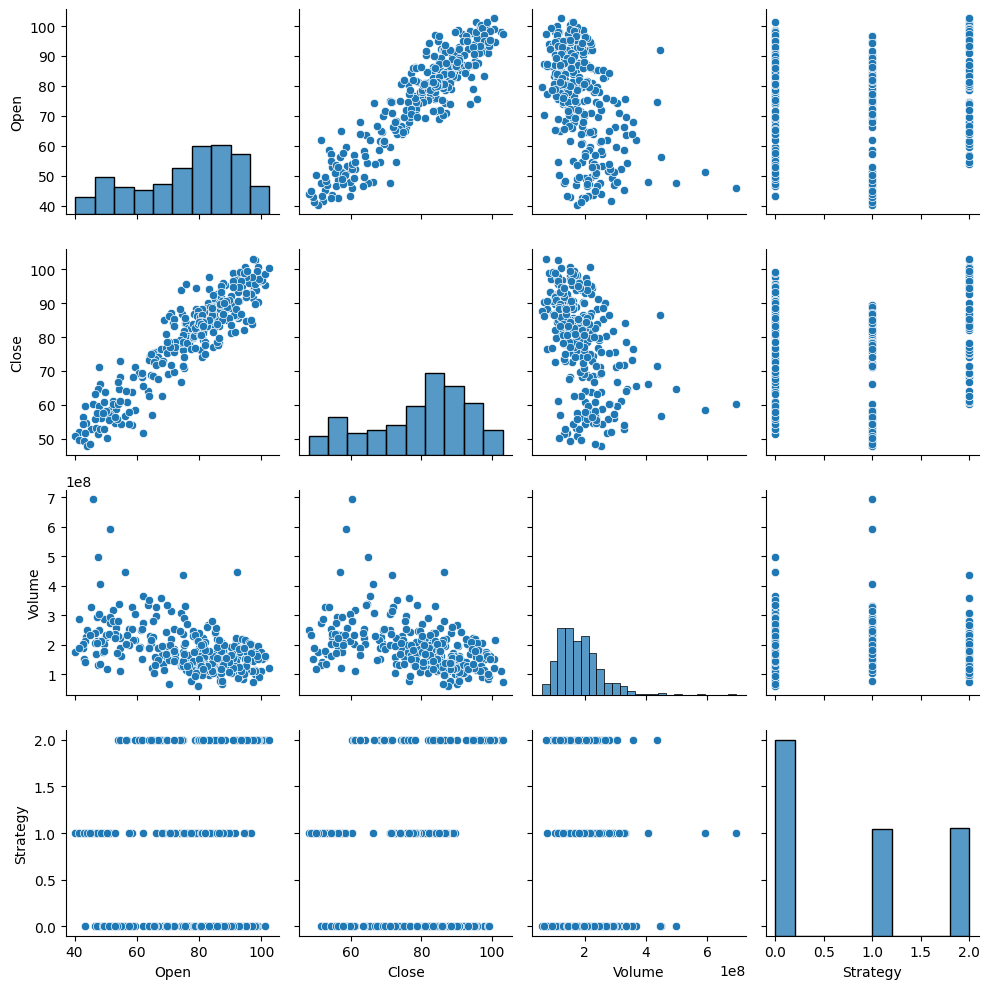

In [1290]:
#Pairplot to identify similarity between features
import seaborn as sns
sns.pairplot(df)
plt.tight_layout()

# **Inference Drawn**
**Linear Relationship With Open And Close,Same Does Not Appear With Volume**

<Axes: xlabel='Date'>

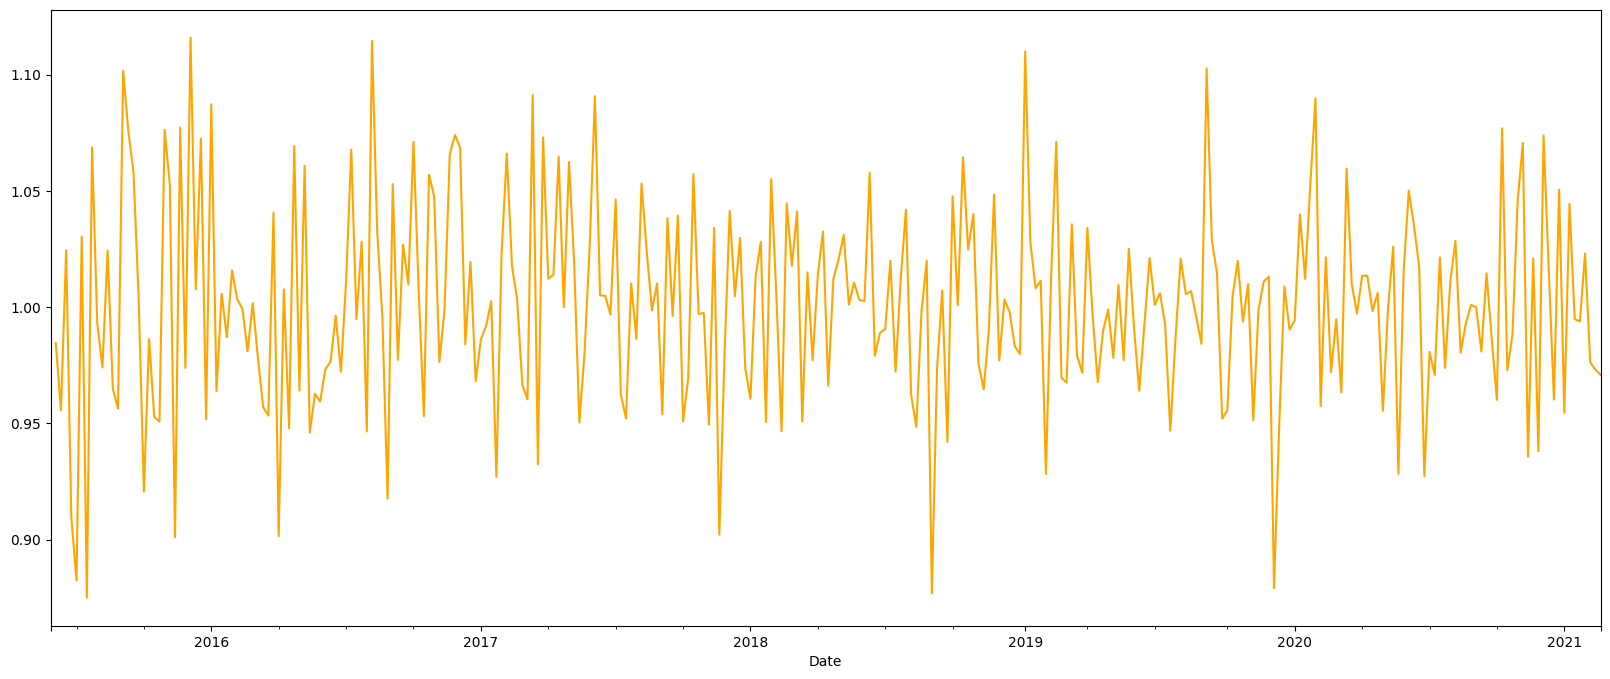

In [1291]:
# Calculating Increase/Dip in the price since the last day
df['percentChange'] = df.Close.div(df.Close.shift())
df['percentChange'].plot(figsize=(20,8),color='orange')

<Axes: xlabel='Date'>

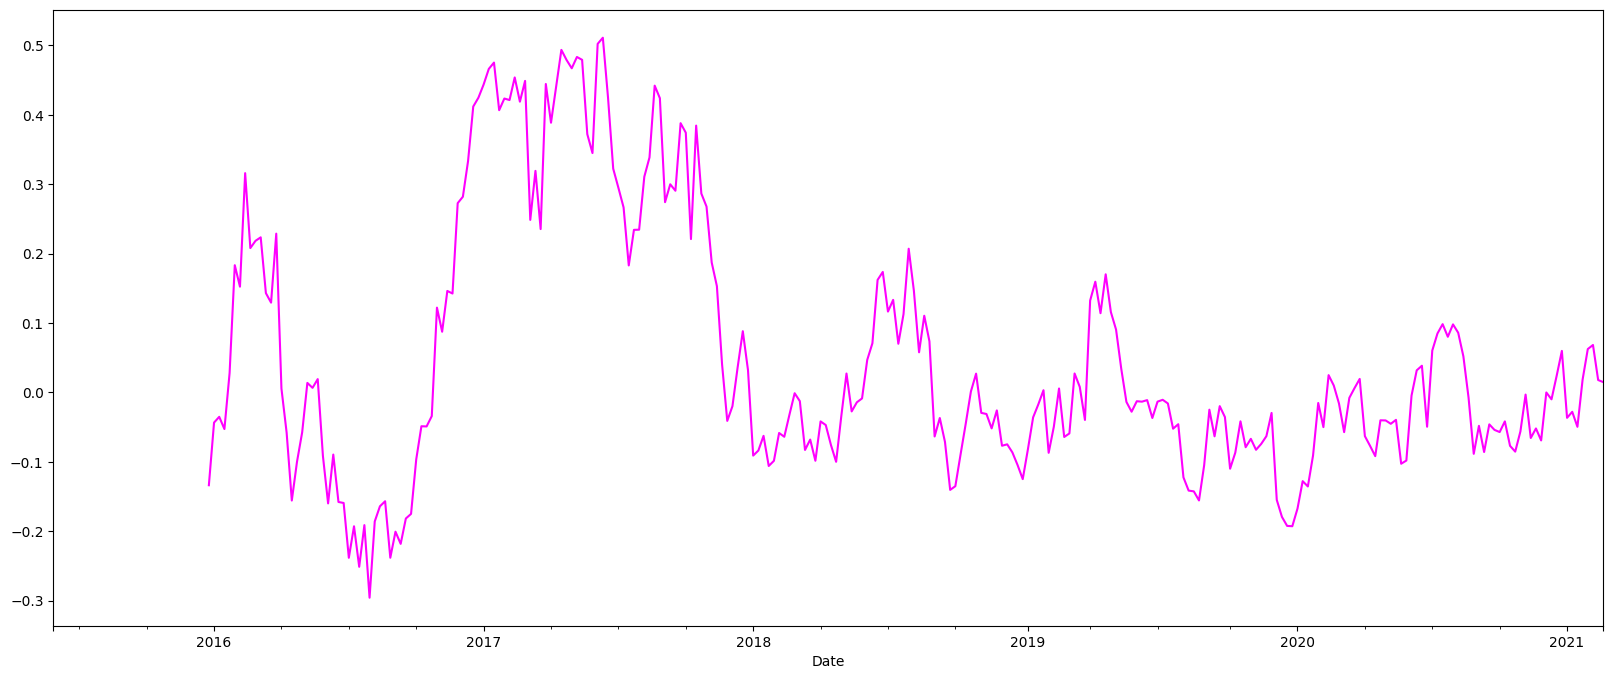

In [1292]:
#Visualising periods of best and worst returns
monthly_return = df['Close'].pct_change(30)
monthly_return.plot(figsize=(20,8),color='magenta')

<Figure size 640x480 with 0 Axes>

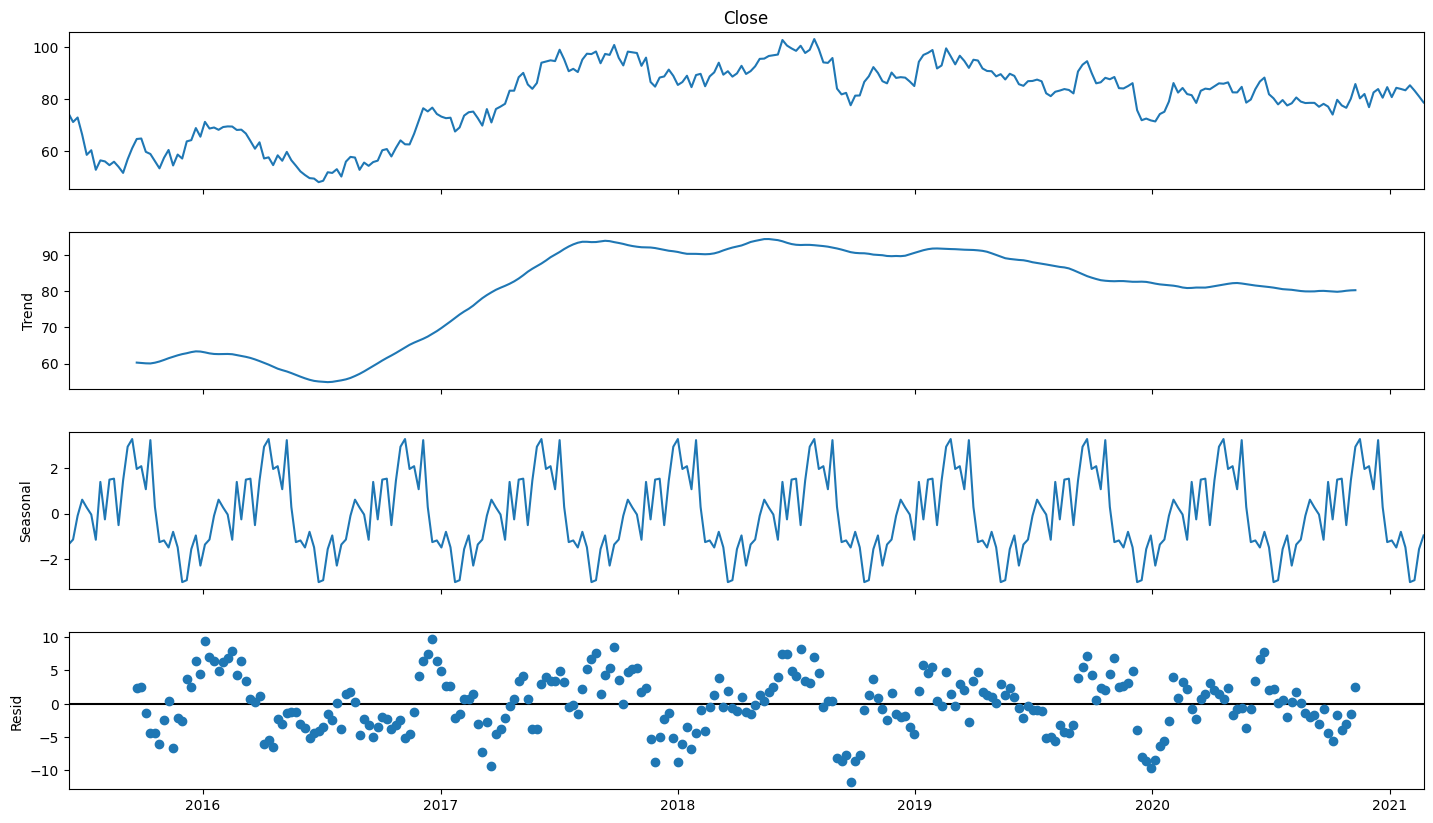

In [1293]:
#Visualising trend, seasonal and residuals for the target variable

from statsmodels.tsa.seasonal import seasonal_decompose
df=df.dropna()
result = seasonal_decompose(df['Close'], model='additive',period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# **Inference Drawn**
**Trend Is Clearly Affecting The Close Prices,Hence We Should Remove The Trend Component**

# **Checking Auto Correlation**
**Autocorrelation to check if there's some dependence between a feature and the lagged version of itself**

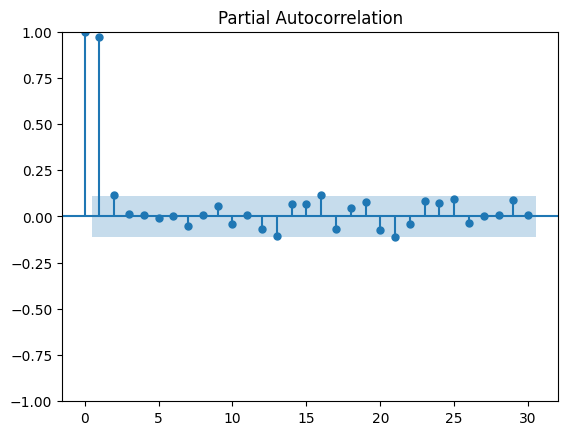

In [1294]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df["Close"],lags=30,method='ywm')
plt.show()

# **Inference Drawn**
**Lags are stastically significant and directly affect the least recent stock price.
p=2**

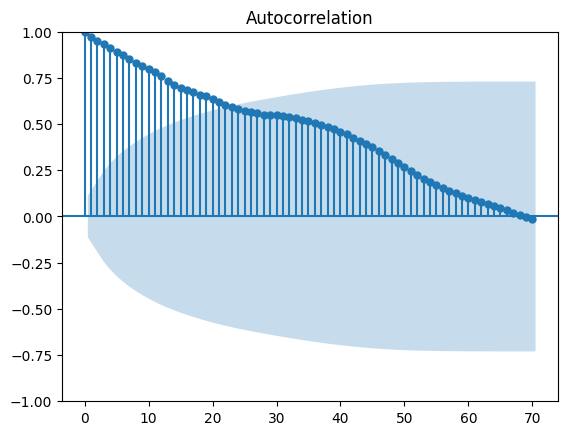

In [1295]:
plot_acf(df["Close"],lags=70)
plt.show()

# **Inference Drawn**
**Data is non stationary as decrease is gradual,hence q=0**

# **Augmented Dicky Fuller(ADF)**
**Augmented Dicky Fuller(ADF) Test Is Performed To Remove The Non Stationarity**

In [1296]:
def print_adf_results(adf_result):
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
           print('\t%s: %.3f' % (key, value))

In [1297]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df["Close"])
print_adf_results(adf)

ADF Statistic: -1.828971
p-value: 0.366176
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


# **Rejecting NULL Hypothesis**

# **Differencing Data**

In [1298]:
transformed1_df = df['Close'].diff().dropna()

# **Removing The Trend Component Through Log Transformations**

In [1299]:
transformed2_df = np.log(df['Close'])

# **Applying ADF Tests**

In [1300]:
dickyfuller1=adfuller(transformed1_df)
print_adf_results(dickyfuller1)

ADF Statistic: -19.639021
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


In [1301]:
dickyfuller2=adfuller(transformed2_df)
print_adf_results(dickyfuller2)

ADF Statistic: -1.733944
p-value: 0.413714
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


# **Accepting NULL Hypothesis**

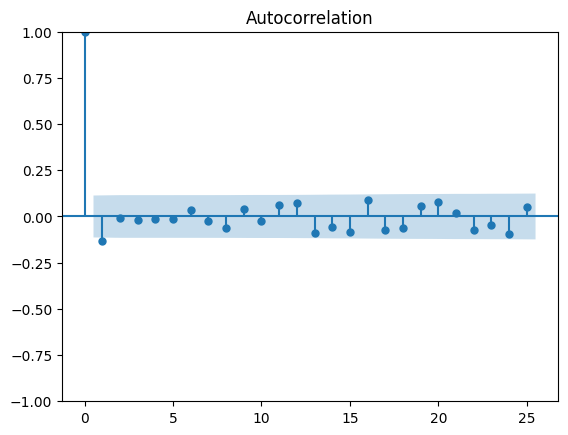

In [1302]:
plot_acf(transformed1_df)
plt.show()

<Axes: xlabel='Date'>

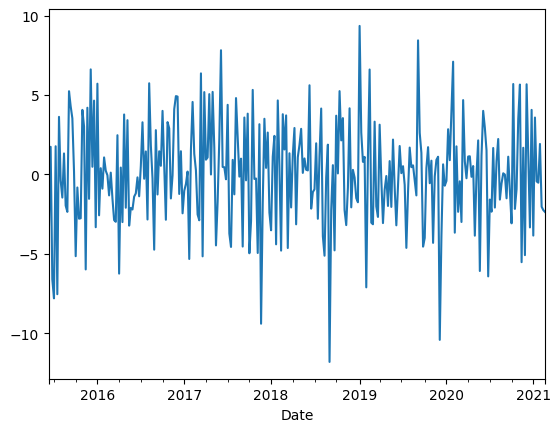

In [1303]:
transformed1_df.plot()

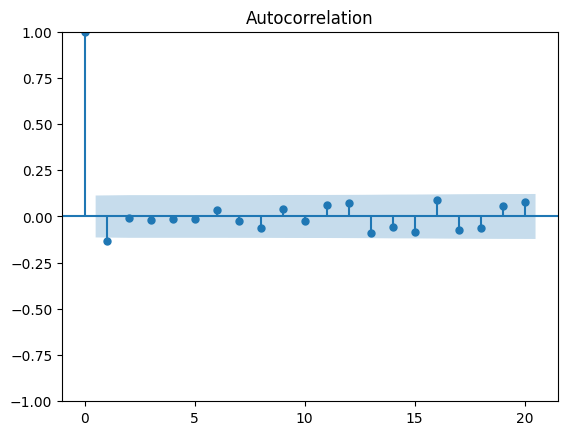

In [1304]:
plot_acf(transformed1_df,lags=20)
plt.show()

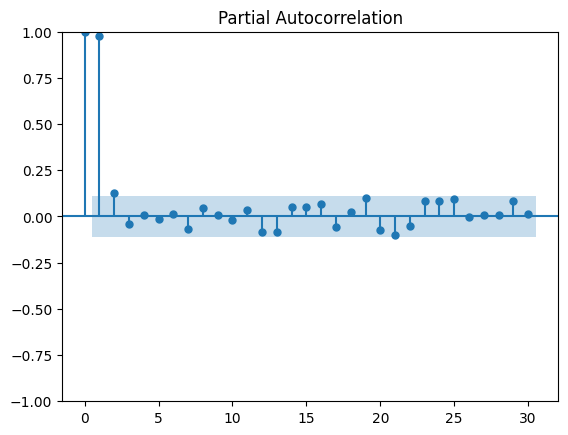

In [1305]:
plot_pacf(transformed2_df,lags=30)
plt.show()

# **Inferences Drawn**
**p=1,d=0,q=1**

# **Preprocessing Data And Feature Engineering**
**Feature Engineering Is Done To Make More Accurate Forecasting Of Close Prices,We Have Added Many Attributes Using Rolling Window Strategies,Also Have Calculated Interaction i.e OpenVol And A Random Measured Metric OpenByVol To Help Us Get Better Results**

# **Model Selection-> SARIMAX Model**
**We Have Selected SARIMAX Model and the though process basically which went behind choosing this process is that it handles the seasonal patterns and non seasonal patterns well,also is much more like a flexible model compared to ARIMA also it captures the trend component.**

In [1306]:
train_data=pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], infer_datetime_format=True)
train_data.set_index('Date', inplace=True)
train_data["OpenVol"]=np.log(train_data['Open']*train_data['Volume'])
train_data["OpenByVol"]=np.log(train_data['Open']/train_data['Volume'])
train_data.sort_index(ascending=True, inplace=True)

window_size=5
train_data['RollingMeanOpen']=train_data['Open'].rolling(window=window_size).mean()
train_data['RollingMeanOpen'].fillna(train_data['RollingMeanOpen'].mean(),inplace=True)
train_data['RollingStdOpen']=train_data['Open'].rolling(window=window_size).std()
train_data['RollingStdOpen'].fillna(train_data['RollingStdOpen'].mean(),inplace=True)
train_data['RollingMeanVolume']=train_data['Volume'].rolling(window=window_size).mean()
train_data['RollingMeanVolume'].fillna(train_data['RollingMeanVolume'].mean(),inplace=True)
train_data['RollingStdVolume']=train_data['Volume'].rolling(window=window_size).std()
train_data['RollingStdVolume'].fillna(train_data['RollingStdVolume'].mean(),inplace=True)
train_data['RollingMeanClose']=train_data['Close'].rolling(window=window_size).mean()
train_data['RollingMeanClose'].fillna(train_data['RollingMeanClose'].mean(),inplace=True)
train_data['RollingStdClose']=train_data['Close'].rolling(window=window_size).std()
train_data['RollingStdClose'].fillna(train_data['RollingStdClose'].mean(),inplace=True)

# Splitting the data into training and validation sets using the simple train_test_split method
from statsmodels.tsa.arima.model import ARIMA

train_size = int(0.8 * len(train_data))
train_set, valid_set = train_data[:train_size], train_data[train_size:]

# Fitting an ARIMA model
#arima_model = ARIMA(train_set["Close"], order=(1, 0, 1))
#arima_fit = arima_model.fit()
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Fitting An Sarimax Model
model_fit = SARIMAX(train_set["Close"],
             exog=train_set[["Open","Volume","OpenVol",'RollingMeanOpen']],
             order=(1, 0, 1),
             seasonal_order=(1,0,1,32)
            )
model = model_fit.fit()
#alpha=0.5

forecast = model.forecast(steps=len(valid_set),exog=valid_set[["Open","Volume","OpenVol",'RollingMeanOpen']])

def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_score = smape(valid_set['Close'], forecast)

print(f"SMAPE Score: {smape_score:.2f}")

from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(valid_set['Close'], forecast)
mse = mean_squared_error(valid_set['Close'], forecast )
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

/tmp/ipykernel_32/2400001974.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_data['Date'] = pd.to_datetime(train_data['Date'], infer_datetime_format=True)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33912D+00    |proj g|=  2.46093D+10


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   2.461D+10   2.339D+00
  F =   2.3391243289653390     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SMAPE Score: 0.01
MAE: 1.6551948362227804
MSE: 4.073154388978737
RMSE: 2.018205735047529


# **Additional Info**
**Also We used ARIMA Model as seen above in the cell,but it didn't give better results as compared to the SARIMAX Model**
**Also We Tried To Creat A Hybrid Model Of ARIMA And SARIMAX as u can see we had chosen a alpha value to take 50% of the model characteristics from both,but That Either could'nt give better results than above one**

# **Forecasting**

In [1307]:
import pandas as pd

# Preprocessing the test dataset where we will forecast the close prices using the model we forecasted.
test_data = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'], infer_datetime_format=True)
test_data.set_index('Date', inplace=True)
test_data["OpenVol"]=np.log(test_data['Open']*test_data['Volume'])
test_data["OpenByVol"]=np.log(test_data['Open']/test_data['Volume'])
test_data.sort_index(ascending=True, inplace=True)
window_size=5
test_data['RollingMeanOpen']=test_data['Open'].rolling(window=window_size).mean()
test_data['RollingMeanOpen'].fillna(test_data['RollingMeanOpen'].mean(),inplace=True)
test_data['RollingStdOpen']=test_data['Open'].rolling(window=window_size).std()
test_data['RollingStdOpen'].fillna(test_data['RollingStdOpen'].mean(),inplace=True)
test_data['RollingMeanVolume']=test_data['Volume'].rolling(window=window_size).mean()
test_data['RollingMeanVolume'].fillna(test_data['RollingMeanVolume'].mean(),inplace=True)
test_data['RollingStdVolume']=test_data['Volume'].rolling(window=window_size).std()
test_data['RollingStdVolume'].fillna(test_data['RollingStdVolume'].mean(),inplace=True)

# Forecasting using the SARIMAX model
forecast = model.forecast(steps=len(test_data), exog=test_data[["Open","Volume","OpenVol",'RollingMeanOpen']])
#arima_forecast = arima_fit.forecast(steps=len(test_data))
#forecast = (alpha * sarima_forecast) + ((1 - alpha) * arima_forecast)

# Creating a DataFrame with the forecasted values
forecast_df = pd.DataFrame({
    'Date': test_data.index,
    'Forecasted_Close': forecast
})

forecast_df = forecast_df.merge(test_data[['Open', 'Volume']], left_on='Date', right_index=True)


print(forecast_df)


                 Date  Forecasted_Close       Open     Volume
2020-01-06 2021-03-01         74.058854  72.708331  205897600
2020-01-13 2021-03-08         74.016663  73.310886  214095600
2020-01-20 2021-03-15         74.429016  70.610119  151601700
2020-01-27 2021-03-22         74.270734  70.256017  193982500
2020-02-03 2021-03-29         75.307201  68.258324  220238400
...               ...               ...        ...        ...
2021-11-01 2022-12-26         63.577213  57.048622  224994700
2021-11-08 2023-01-02         63.544286  60.569661  176020500
2021-11-15 2023-01-09         63.788483  61.446777  181478600
2021-11-22 2023-01-16         64.366080  55.447711  162471700
2021-11-29 2023-01-23         64.419659  57.008939  178924000

[100 rows x 4 columns]


/tmp/ipykernel_32/3903387707.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test_data['Date'] = pd.to_datetime(test_data['Date'], infer_datetime_format=True)


# **Prediction Strategy**

# **Feature Engineering**
**Feature Engineering Is Done To Make Correct Strategy Predictions,we have introduced new columns such as RSI,EMA,SMA To Build Our Model Better**

In [1308]:
import pandas as pd


train_data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv',parse_dates=['Date'])
train_data.set_index("Date",inplace=True)
strategy_mapping = {'Hold': 0, 'Buy': 1, 'Sell': 2}

# Apply the mapping to the 'Strategy' column
train_data['Strategy'] = train_data['Strategy'].map(strategy_mapping)

train_data['SMA'] = train_data['Close'].rolling(window=5, min_periods=1).mean()
train_data['EMA'] = train_data['Close'].ewm(span=5, adjust=False).mean()

#Feature Engineering Is Done To Make More Accurate Predictions Of Strategy Involved.

train_data['BullishEngulfing'] = np.where(
        (train_data['Close'].shift(1) < train_data['Open'].shift(1)) &
        (train_data['Close'] > train_data['Open']) &
        (train_data['Close'].shift(1) > train_data['Open']) &
        (train_data['Open'] < train_data['Close'].shift(1)),
        True,
        False
    )

In [1309]:
def calculate_rsi(data, window=5):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=0).mean()
    avg_loss = loss.rolling(window=window, min_periods=0).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

calculate_rsi(train_data, window=5)

In [1310]:
train_data.head()

,id,Open,Close,Volume,Strategy,SMA,EMA,BullishEngulfing,RSI
Date,,,,,,,,,
2015-06-01,0,66.208486,75.609978,298506300,0,75.609978,75.609978,False,NaN
2015-06-08,1,64.116235,74.443331,227974800,0,75.026655,75.221096,False,0.000000
2015-06-15,2,47.701942,71.140831,250670900,1,73.731380,73.861008,False,0.000000
2015-06-22,3,54.754816,72.881344,223614300,0,73.518871,73.534453,False,28.029110
2015-06-29,4,48.031899,66.284718,406814900,1,72.072040,71.117875,False,13.591078


In [1311]:
train_data['RSI'] = train_data['RSI'].fillna(50)

In [1312]:
train_data['RSI']

Date
2015-06-01    50.000000
2015-06-08     0.000000
2015-06-15     0.000000
2015-06-22    28.029110
2015-06-29    13.591078
                ...    
2021-01-25    61.471245
2021-02-01    53.454344
2021-02-08    64.883449
2021-02-15    26.908993
2021-02-22    21.206268
Name: RSI, Length: 300, dtype: float64

In [1313]:
train_data['BullishEngulfing']

Date
2015-06-01    False
2015-06-08    False
2015-06-15    False
2015-06-22    False
2015-06-29    False
              ...  
2021-01-25    False
2021-02-01    False
2021-02-08    False
2021-02-15    False
2021-02-22    False
Name: BullishEngulfing, Length: 300, dtype: bool

In [1314]:
train_data = train_data.dropna()
train_data.head()

,id,Open,Close,Volume,Strategy,SMA,EMA,BullishEngulfing,RSI
Date,,,,,,,,,
2015-06-01,0,66.208486,75.609978,298506300,0,75.609978,75.609978,False,50.000000
2015-06-08,1,64.116235,74.443331,227974800,0,75.026655,75.221096,False,0.000000
2015-06-15,2,47.701942,71.140831,250670900,1,73.731380,73.861008,False,0.000000
2015-06-22,3,54.754816,72.881344,223614300,0,73.518871,73.534453,False,28.029110
2015-06-29,4,48.031899,66.284718,406814900,1,72.072040,71.117875,False,13.591078


# **Model Building**
**We Use The Random Forest Classifier Model To Build The Model,as it's usually a better model for multi-class classifcation and also as it combines multiple decison tress i.e ensemble learning**.

In [1380]:
import numpy as np

#X_train = X_train.values.reshape(-1, 1)
#X_test = X_test.values.reshape(-1, 1)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

train_data['RollingMeanClose']=train_data['Close'].rolling(window=window_size).mean()
train_data['RollingMeanClose'].fillna(train_data['RollingMeanClose'].mean(),inplace=True)
X = train_data[['Open','Close','RollingMeanClose','SMA','EMA','RSI']]
y = train_data['Strategy']
from sklearn.preprocessing import StandardScaler
sc_x= StandardScaler()
X = sc_x.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.7111111111111111


In [1381]:
forecast_df = forecast_df.rename(columns={'Forecasted_Close': 'Close'})

In [1386]:
forecast_df=forecast_df.drop(columns=['Open'])

In [1387]:
forecast_df = forecast_df.merge(test_data[['Open', 'Volume']], left_on='Date', right_index=True)

In [1388]:
forecast_df

,Date,Close,Strategy,RollingMeanClose,SMA,EMA,RSI,Open,Volume
0,2021-03-01,74.058854,Buy,1.395293,74.058854,74.058854,48.694857,72.708331,205897600
1,2021-03-08,74.016663,Buy,1.395293,74.037758,74.044790,0.000000,73.310886,214095600
2,2021-03-15,74.429016,Hold,1.395293,74.168178,74.172865,90.717945,70.610119,151601700
3,2021-03-22,74.270734,Buy,1.395293,74.193817,74.205488,67.287102,70.256017,193982500
4,2021-03-29,75.307201,Sell,0.525008,74.416493,74.572726,87.844899,68.258324,220238400
...,...,...,...,...,...,...,...,...,...
95,2022-12-26,63.577213,Hold,1.542360,62.706429,63.165342,48.737017,57.048622,224994700
96,2023-01-02,63.544286,Buy,0.955539,63.309691,63.291657,44.563292,60.569661,176020500
97,2023-01-09,63.788483,Hold,0.411113,63.714410,63.457265,39.770639,61.446777,181478600
98,2023-01-16,64.366080,Hold,0.413221,63.930561,63.760203,41.841700,55.447711,162471700


# **Prediction**

In [1389]:
#More Columns Are Added To The Created Dataframe To Make The Correct Predictions
forecast_df['RollingMeanClose']=forecast_df['Close'].rolling(window=window_size).std()
forecast_df['RollingMeanClose'].fillna(forecast_df['RollingMeanClose'].mean(),inplace=True)
forecast_df['SMA'] = forecast_df['Close'].rolling(window=5, min_periods=1).mean()
forecast_df['SMA'].fillna(forecast_df['SMA'].mean(),inplace=True)
forecast_df['EMA'] = forecast_df['Close'].ewm(span=5, adjust=False).mean()
forecast_df['EMA'].fillna(forecast_df['EMA'].mean(),inplace=True)
calculate_rsi(forecast_df, window=14)
forecast_df['RSI'].fillna(forecast_df['RSI'].mean(),inplace=True)
X_forecast = forecast_df[['Open','Close','RollingMeanClose','SMA','EMA','RSI']]

from sklearn.preprocessing import StandardScaler
sc_x= StandardScaler()
X_forecast = sc_x.fit_transform(X_forecast)

# Predicting strategies for the forecasted data
predicted_strategies = model.predict(X_forecast)

def suggest_strategy(prediction):
    if prediction == 0:
        return 'Hold'
    elif prediction == 1:
        return 'Buy'
    else:
        return 'Sell'

predicted_strategies_strategies = [suggest_strategy(prediction) for prediction in predicted_strategies]


forecast_df['Strategy'] = predicted_strategies


In [1390]:
forecast_df.reset_index(drop=True, inplace=True)
#forecast_df.drop(columns=['Return'], inplace=True)
# Creating a mapping dictionary to map values to strategy labels
strategy_mapping = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
# Applying the mapping to the "Strategy" column
forecast_df['Strategy'] = forecast_df['Strategy'].map(strategy_mapping)
forecast_df.to_csv('submission.csv', index_label='id')
forecast_df.head()

,Date,Close,Strategy,RollingMeanClose,SMA,EMA,RSI,Open,Volume
0,2021-03-01,74.058854,Hold,1.395293,74.058854,74.058854,48.694857,72.708331,205897600
1,2021-03-08,74.016663,Buy,1.395293,74.037758,74.044790,0.000000,73.310886,214095600
2,2021-03-15,74.429016,Hold,1.395293,74.168178,74.172865,90.717945,70.610119,151601700
3,2021-03-22,74.270734,Hold,1.395293,74.193817,74.205488,67.287102,70.256017,193982500
4,2021-03-29,75.307201,Sell,0.525008,74.416493,74.572726,87.844899,68.258324,220238400


# **Submission**

In [1391]:
forecast_df=forecast_df[['Date','Close','Strategy']]
forecast_df.to_csv('submission.csv', index_label='id')
forecast_df.head()

,Date,Close,Strategy
0,2021-03-01,74.058854,Hold
1,2021-03-08,74.016663,Buy
2,2021-03-15,74.429016,Hold
3,2021-03-22,74.270734,Hold
4,2021-03-29,75.307201,Sell
